# ACTIVIDAD 2:
## CLASIFICACIÓN DE TEXTOS.

***

### JOSE LÓPEZ GALDÓN

***

#### Guión de la actividad

1. Lea el contenido del fichero csv en un DataFrame. Se sugiere utilizar la función **pandas.read_csv**. Atención a la codificación de los datos entrantes.


2. Realice el pre-procesamiento que considere necesario. Puede utilizar funciones de la librería NLTK o spaCy, a su voluntad. Recomendamos una escritura modular del código, para poder hacer pruebas posteriormente, viendo si se obtienen mejores resultados al utilizar stop-words, al realizar una extracción de formas canónicas, etc.


3. Divida el conjunto de documentos en un subconjunto de entrenamiento y otro de evaluación.


4. Convierta el corpus de documentos en una matriz **TF-idf**. Lo más cómodo es utilizar el vectorizador **TfidfVectorizer**, que forma parte de **sklearn**. ¿Tiene influencia en el resultado final el número máximo de features a utilizar?


5. Llegados a este punto, realice modelos de entrenamiento al menos con algoritmos de clasificador bayesiano ingenuo y máquinas SVM. Obtenga resultados de precisión de la clasificación, así como las matrices de confusión para ambos modelos.


6. Comente los resultados obtenidos. ¿Qué factores influyen? ¿Los resultadosobtenidos son los esperados inicialmente? ¿A qué se deben estos resultados? Piense en la calidad del conjunto de datos con los que está trabajando

***

#### Librerías
Comenzamos cargando las librerías necesarias para este ejercicio:

In [1]:
# Importamos pandas y numpy
import numpy as np
import pandas as pd

# Imoportamos las librerías de visualización
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

# Importamos NLTK
import nltk, re, pprint
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer

# Importamos sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import naive_bayes, svm
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

# Visualizar DF
from IPython.display import display, HTML

#### Funciones

Cargamos las funciones para plotear la matriz de confusión:

#### Carga de ficheros

Continuamos el ejercicio cargando el fichero `hotel.csv`:

In [2]:
# Cargamos el fichero csv con la función que recomienda el enunciado:
corpus = pd.read_csv("hotel.csv", encoding="utf-8")

# Visualizamos los datos
display(HTML(corpus.to_html()))

,text,label
0,Es un gran hotel; el mejor de Asunción. Buenas habitaciones; la gente es maravillosa; el servicio es excelente; la comida muy buena. Pero me cargaron doble mi estadia; una por expedia y una en el hotel al hacer el checkout. Tuve que llamar varias veces y estar en el teléfono horas para que me devolvieran el dinero. Lo único malo es el Gimnasio; ellos anuncian un Gimnasio pero es solo un pard e caminadoras; ojalá tuvieran mejores equipos.,3
1,"hola. no suelo criticar jamas lo que paso pero esta vez me animo a hacerlo. Fue mi segunda estancia -y mala experiencia- en el hotel. La primera fue por probarlo porque me cautivo el concepto ""ecologico"" del hotel. La segunda fue forzada; no tenia lugar a donde alojarme.Primera cosa. Un hotel que se supone ecologicamente sustentable puede descargar litros y litros de agua cuando descarga? Asi y todo cuando es de ""lluvia"" supuestamente?-Puede tener tantos accesorios en el banio con plastico y nada.. absolutamente nada es biodegrable y menos cumple con los conceptos de sustentabilidad tan buscados ultimamente?- Puede uno pagar U$ 600 por la suite presidencial y al salir de la ducha uno tiene que caminar unos metros mojados a las busqueda del tesoro - llamese el toallon- corriendo el riesgo de resvalarse y hacer de este tu ultimo viaje?- Eso si; la atencion muy personalizada... La noche anterior estuve en una habitcion simple y previamete se me habia dicho que me podia mudar a la suite presidencial a las 12 del mediodia... Les parece interesante que le toquen el timbre desde las 10 a las 11 diferentes personas diciendoles que ""ya se puede mudar""- A los que viajamos de negocio... Que es lo primero que buscamos? creo que un buen escritorio; conexion para nuestras laptops y cosas minimas como tener un toma corriente en el mismo lugar de trabajo.. Disparatado? Pues si; no lo tiene. Ni la habitacion barata y tampoco la ""suite presidencial"". - Que si ven en la carta de la ""suite"" la tentadora descripcion de las cervezas frias que esperan por uno despues de un dia arduo? Feliz uno corre a la heladera saboreandola de antemano.. y oh sorpresa..!! NO hay cerveza!- Como se ven dandose una hermoso banio de inmersion y zas! el telefono suena en la habitacion y uno tiene que salirse de la tina; hacer la busqueda del gran tesoro -toallas- en el hotel la mision? No seria nada si el llamado es para avisarle a uno que se gano la loteria... Pero que pasa si uno atiende y cortan? y si lo hacen 3 veces mas en el termino de 5 minutos?No quiero seguir; solo ser muy honestos al menos con los viajeros frecuentes que tratamos de balancear nuestra vida personal con la de negocios.",3
2,Escogi meses antes de mi boda una habitacion para hacer mi sesion de fotos; estuve como 1 hora en el hotel viendo las habitaciones hasta que finalmente escogi la que me encanto; Pagué apenas me pidieron que pase; pero cuando hago el check in; me dan otra; sin ninguna explicacion lógica; ningun gesto de disculpas; nada. Quedé muy decepcionada porque esperaba otro tipo de atención.,3
3,Voy a se Lo mas equitativo posible; porque soy persona bien intencionada; me encanto wilma; la señora que adea la habitación; es la clasica persona sencillita; predispuesta; educada; y se nota de un buen caracter humano; En principio; el primer llamado que efectue fue de una atencion inmejorada,3
4,Esta es una experiencia de septiembre de 2016; asi que quizas algunas cosas cambiaronReservé la senior suite para mi luna de miel; la organizadora del paquete de luna de miel (miembro del hotel) fue muy atenta y me ayudó muy amablemente. Le había comentado a la organizadora que no tenia a nadie que me ayude a poner las flores en el auto que me iba a llevar a la iglesia en ese dia; por lo que ella me dijo que no me preocupe; que el personal me iba a ayudar sin ningun problema.Llegó el dia de la boda; me preparé en la suite y llamé a recepción a pedir ayuda con las flores para el auto y la recepcionista solo se limitó a decirme que a ella no

In [3]:
corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    200 non-null    object
 1   label   200 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.2+ KB


Como vemos tenemos el fichero cargado correctamente. Contamos 200 registros (comentarios en español) y el fichero presenta dos columnas:

- `text`: Comentario del usuario
- `label`: Calificación

***

#### Pre-procesamiento

A continuación, realizaremos un pre-procesamiento simple del corpus con NLTK. Pero primero separaremos los documentos y categorías:

In [4]:
# Vamos a separar los documentos y sus categorías. 
# docs y categs son series de Pandas
# Hay que separar las categorías de los documentos para usar 
# estos últimos y obtener la matriz BOW o Tf-idf

docs = corpus.iloc[:,0] # extract column with review (primera columna)
categs = corpus.iloc[:,-1] # extract column with label (ultima columna)

In [5]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('spanish')

def normalize_document(doc):
    # pasamos las letras a minúsculas, eliminamos los carácteres especiales y espaciones en blaco
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenizamos el documento
    tokens = wpt.tokenize(doc)
    # quitamos las stopwords
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # creamos un nuevo documento
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [6]:
# Usamos la función creada anteriormente
corpus_procesado = normalize_corpus(docs)

# Visualizamos el resultado
corpus_procesado

array(['gran hotel mejor asuncin buenas habitaciones gente maravillosa servicio excelente comida buena cargaron doble estadia expedia hotel hacer checkout llamar varias veces telfono horas devolvieran dinero nico malo gimnasio anuncian gimnasio solo pard caminadoras ojal mejores equipos',
       'hola suelo criticar jamas paso vez animo hacerlo segunda estancia mala experiencia hotel primera probarlo cautivo concepto ecologico hotel segunda forzada tenia lugar alojarmeprimera cosa hotel supone ecologicamente sustentable puede descargar litros litros agua descarga asi lluvia supuestamentepuede tener tantos accesorios banio plastico absolutamente biodegrable menos cumple conceptos sustentabilidad tan buscados ultimamente puede pagar u suite presidencial salir ducha caminar metros mojados busqueda tesoro llamese toallon corriendo riesgo resvalarse hacer ultimo viaje si atencion personalizada noche anterior habitcion simple previamete habia dicho podia mudar suite presidencial mediodia par

Como podemos obervar ya tenemos el corpus procesado, es decir, tenemos un array donde cada vector son los comentarios del pandas procesados...

***

#### Obtención de las matrices BOW y Tf-idf

Ahora generaremos las matrices BOW y Tf-idf:

In [7]:
# tokenizamos los documentos y convertimos en matriz BOW
# A pesar de parecer que todo son ceros, está bien porque esos ceros que vemos son palabras que no
# saldran 
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words='english')
docs_vec = vectorizer.fit_transform(docs)
docs_vec = docs_vec.todense() # convierte la matriz en densa
docs_vec

matrix([[0, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [8]:
# Construimos la matriz formato Tf-idf
tfidf = TfidfTransformer() 
docs_tfidf = tfidf.fit_transform(docs_vec)
docs_tfidf = docs_tfidf.todense()
docs_tfidf

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.11807236,
         0.        ],
        [0.04579273, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

***

#### Preparación de los subconjuntos de entrenamiento y test

Vamos a dividir mediante la función `train_test_split`, de manera que tengamos un 30% para muestra y un 70% de entrenamiento:

In [9]:
# Creamos la partición, especificando la semilla para reproducir los resultados...
docs_train, docs_test, categs_train, categs_test = train_test_split(docs_tfidf, categs, test_size = 0.30, 
                                                                    random_state = 2122)

In [10]:
# Realizamos un encoding de las categorías 3 y 5 para pasarlas a 0 y 1
encoder = LabelEncoder()
categs_train_encod = encoder.fit_transform(y=categs_train)

categs_test_encod = encoder.fit_transform(categs_test)

Ahora comprobaremos si la muestra que hemos obtenido es representativa de la realidad:

In [11]:
# Labels del universo
corpus['label'].value_counts(normalize=True)

3    0.555
5    0.445
Name: label, dtype: float64

In [12]:
# Labels de training
categs_train.value_counts(normalize=True)

3    0.557143
5    0.442857
Name: label, dtype: float64

In [13]:
# Labels de testing
categs_test.value_counts(normalize=True)

3    0.55
5    0.45
Name: label, dtype: float64

Como podemos observar, las muestras de entrenamiento y test son representativas del unvierso.

***

***

#### Clasificador ingenuo bayesiano

In [14]:
clf = naive_bayes.MultinomialNB()
clf.fit(docs_train, categs_train)

MultinomialNB()

In [15]:
# Predicción del set de test
categs_pred_Bayes = clf.predict(docs_test)

##### Métricas

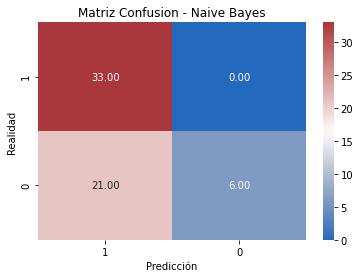

In [16]:
# Plot con un heatmap
sns.heatmap(metrics.confusion_matrix(categs_test, categs_pred_Bayes),annot=True, fmt=".2f", 
            cmap="vlag", xticklabels = ["1", "0"] , yticklabels = ["1", "0"])

# Título y etiquetas
plt.title("Matriz Confusion - Naive Bayes")
plt.ylabel("Realidad")
plt.xlabel("Predicción")
plt.show()

In [17]:
f'El accuracy del método Naive Bayes es {metrics.accuracy_score(categs_pred_Bayes, categs_test)*100}%'

'El accuracy del método Naive Bayes es 65.0%'

#### Máquina de Soporte Vectorial (SVM)

In [18]:
from sklearn import svm
SVM = svm.SVC()
SVM.fit(docs_train, categs_train)

SVC()

In [19]:
# Predicción del set de test
categs_pred_SVM = SVM.predict(docs_test)

##### Métricas

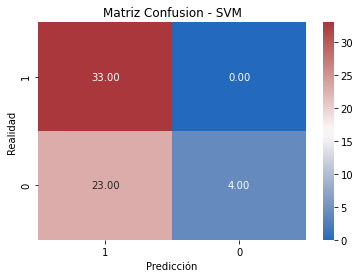

In [20]:
# Plot con un heatmap
sns.heatmap(metrics.confusion_matrix(categs_test, categs_pred_SVM),annot=True, fmt=".2f", 
            cmap="vlag", xticklabels = ["1", "0"] , yticklabels = ["1", "0"])

# Título y etiquetas
plt.title("Matriz Confusion - SVM")
plt.ylabel("Realidad")
plt.xlabel("Predicción")
plt.show()

In [21]:
f'El accuracy del método SVM es {metrics.accuracy_score(categs_pred_SVM, categs_test)*100}%'

'El accuracy del método SVM es 61.66666666666667%'

#### Máquina de Soporte Vectorial Tuneada

In [22]:
# Definimos los parámetros
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001,'auto'], 
              'kernel': ['rbf','poly','sigmoid','linear']}

# Cargamos y entrenamos el modelo
grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3)
grid.fit(docs_train, categs_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.571, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.571, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.571, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.536, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.536, total=   0.1s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ......... C=0.1, gamma=1, kernel=poly, score=0.571, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ......... C=0.1, gamma=1, kernel=poly, score=0.571, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ......... C=0.1, gamma=1, kernel=poly, score=0.571, total=   0.1s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ......... C=0.1, gamma=1, kernel=poly, score=0.536, total=   0.1s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ......... C=0.1, gamma=1, kernel=poly, score=0.536, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] .

[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.571, total=   0.1s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.536, total=   0.1s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.536, total=   0.1s
[CV] C=0.1, gamma=0.001, kernel=poly .................................
[CV] ..... C=0.1, gamma=0.001, kernel=poly, score=0.571, total=   0.1s
[CV] C=0.1, gamma=0.001, kernel=poly .................................
[CV] ..... C=0.1, gamma=0.001, kernel=poly, score=0.571, total=   0.1s
[CV] C=0.1, gamma=0.001, kernel=poly .................................
[CV] ..... C=0.1, gamma=0.001, kernel=poly, score=0.571, total=   0.1s
[CV] C=0.1, gamma=0.001, kernel=poly .................................
[CV] ..... C=0.1, gamma=0.001, kernel=poly, score=0.536, total=   0.1s
[CV] C=0.1, gamma=0.001, kernel=poly .................................
[CV] .

[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.571, total=   0.1s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.571, total=   0.1s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.571, total=   0.1s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.536, total=   0.1s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.536, total=   0.1s
[CV] C=1, gamma=0.1, kernel=poly .....................................
[CV] ......... C=1, gamma=0.1, kernel=poly, score=0.571, total=   0.1s
[CV] C=1, gamma=0.1, kernel=poly .....................................
[CV] ......... C=1, gamma=0.1, kernel=poly, score=0.571, total=   0.1s
[CV] C=1, gamma=0.1, kernel=poly .....................................
[CV] .

[CV] ..... C=1, gamma=0.001, kernel=linear, score=0.536, total=   0.1s
[CV] C=1, gamma=auto, kernel=rbf .....................................
[CV] ......... C=1, gamma=auto, kernel=rbf, score=0.571, total=   0.1s
[CV] C=1, gamma=auto, kernel=rbf .....................................
[CV] ......... C=1, gamma=auto, kernel=rbf, score=0.571, total=   0.1s
[CV] C=1, gamma=auto, kernel=rbf .....................................
[CV] ......... C=1, gamma=auto, kernel=rbf, score=0.571, total=   0.1s
[CV] C=1, gamma=auto, kernel=rbf .....................................
[CV] ......... C=1, gamma=auto, kernel=rbf, score=0.536, total=   0.1s
[CV] C=1, gamma=auto, kernel=rbf .....................................
[CV] ......... C=1, gamma=auto, kernel=rbf, score=0.536, total=   0.1s
[CV] C=1, gamma=auto, kernel=poly ....................................
[CV] ........ C=1, gamma=auto, kernel=poly, score=0.571, total=   0.1s
[CV] C=1, gamma=auto, kernel=poly ....................................
[CV] .

[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.571, total=   0.1s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.571, total=   0.1s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.536, total=   0.1s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.536, total=   0.1s
[CV] C=10, gamma=0.01, kernel=poly ...................................
[CV] ....... C=10, gamma=0.01, kernel=poly, score=0.571, total=   0.0s
[CV] C=10, gamma=0.01, kernel=poly ...................................
[CV] ....... C=10, gamma=0.01, kernel=poly, score=0.571, total=   0.0s
[CV] C=10, gamma=0.01, kernel=poly ...................................
[CV] ....... C=10, gamma=0.01, kernel=poly, score=0.571, total=   0.0s
[CV] C=10, gamma=0.01, kernel=poly ...................................
[CV] .

[CV] .......... C=100, gamma=1, kernel=rbf, score=0.714, total=   0.1s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] .......... C=100, gamma=1, kernel=rbf, score=0.750, total=   0.0s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] .......... C=100, gamma=1, kernel=rbf, score=0.679, total=   0.0s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] .......... C=100, gamma=1, kernel=rbf, score=0.607, total=   0.0s
[CV] C=100, gamma=1, kernel=poly .....................................
[CV] ......... C=100, gamma=1, kernel=poly, score=0.571, total=   0.0s
[CV] C=100, gamma=1, kernel=poly .....................................
[CV] ......... C=100, gamma=1, kernel=poly, score=0.571, total=   0.1s
[CV] C=100, gamma=1, kernel=poly .....................................
[CV] ......... C=100, gamma=1, kernel=poly, score=0.571, total=   0.0s
[CV] C=100, gamma=1, kernel=poly .....................................
[CV] .

[CV] ...... C=100, gamma=0.001, kernel=rbf, score=0.536, total=   0.1s
[CV] C=100, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=100, gamma=0.001, kernel=rbf, score=0.536, total=   0.0s
[CV] C=100, gamma=0.001, kernel=poly .................................
[CV] ..... C=100, gamma=0.001, kernel=poly, score=0.571, total=   0.0s
[CV] C=100, gamma=0.001, kernel=poly .................................
[CV] ..... C=100, gamma=0.001, kernel=poly, score=0.571, total=   0.0s
[CV] C=100, gamma=0.001, kernel=poly .................................
[CV] ..... C=100, gamma=0.001, kernel=poly, score=0.571, total=   0.0s
[CV] C=100, gamma=0.001, kernel=poly .................................
[CV] ..... C=100, gamma=0.001, kernel=poly, score=0.536, total=   0.1s
[CV] C=100, gamma=0.001, kernel=poly .................................
[CV] ..... C=100, gamma=0.001, kernel=poly, score=0.536, total=   0.0s
[CV] C=100, gamma=0.001, kernel=sigmoid ..............................
[CV] .

[CV] ....... C=1000, gamma=0.1, kernel=rbf, score=0.536, total=   0.1s
[CV] C=1000, gamma=0.1, kernel=poly ..................................
[CV] ...... C=1000, gamma=0.1, kernel=poly, score=0.571, total=   0.1s
[CV] C=1000, gamma=0.1, kernel=poly ..................................
[CV] ...... C=1000, gamma=0.1, kernel=poly, score=0.571, total=   0.1s
[CV] C=1000, gamma=0.1, kernel=poly ..................................
[CV] ...... C=1000, gamma=0.1, kernel=poly, score=0.571, total=   0.1s
[CV] C=1000, gamma=0.1, kernel=poly ..................................
[CV] ...... C=1000, gamma=0.1, kernel=poly, score=0.536, total=   0.1s
[CV] C=1000, gamma=0.1, kernel=poly ..................................
[CV] ...... C=1000, gamma=0.1, kernel=poly, score=0.536, total=   0.1s
[CV] C=1000, gamma=0.1, kernel=sigmoid ...............................
[CV] ... C=1000, gamma=0.1, kernel=sigmoid, score=0.643, total=   0.0s
[CV] C=1000, gamma=0.1, kernel=sigmoid ...............................
[CV] .

[CV] ..... C=1000, gamma=auto, kernel=poly, score=0.571, total=   0.0s
[CV] C=1000, gamma=auto, kernel=poly .................................
[CV] ..... C=1000, gamma=auto, kernel=poly, score=0.571, total=   0.0s
[CV] C=1000, gamma=auto, kernel=poly .................................
[CV] ..... C=1000, gamma=auto, kernel=poly, score=0.571, total=   0.0s
[CV] C=1000, gamma=auto, kernel=poly .................................
[CV] ..... C=1000, gamma=auto, kernel=poly, score=0.536, total=   0.0s
[CV] C=1000, gamma=auto, kernel=poly .................................
[CV] ..... C=1000, gamma=auto, kernel=poly, score=0.536, total=   0.0s
[CV] C=1000, gamma=auto, kernel=sigmoid ..............................
[CV] .. C=1000, gamma=auto, kernel=sigmoid, score=0.571, total=   0.1s
[CV] C=1000, gamma=auto, kernel=sigmoid ..............................
[CV] .. C=1000, gamma=auto, kernel=sigmoid, score=0.571, total=   0.0s
[CV] C=1000, gamma=auto, kernel=sigmoid ..............................
[CV] .

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   34.4s finished


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 'auto'],
                         'kernel': ['rbf', 'poly', 'sigmoid', 'linear']},
             verbose=3)

In [23]:
# Predicción del set de test
grid_predictions = grid.predict(docs_test)

##### Métricas

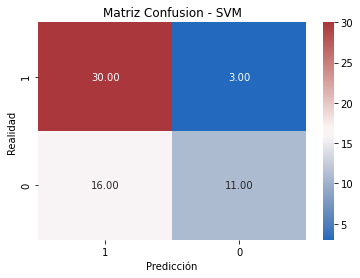

In [24]:
# Plot con un heatmap
sns.heatmap(metrics.confusion_matrix(categs_test, grid_predictions),annot=True, fmt=".2f", 
            cmap="vlag", xticklabels = ["1", "0"] , yticklabels = ["1", "0"])

# Título y etiquetas
plt.title("Matriz Confusion - SVM")
plt.ylabel("Realidad")
plt.xlabel("Predicción")
plt.show()

In [25]:
f'El accuracy del SVM tuneado es {metrics.accuracy_score(grid_predictions, categs_test)*100}%'

'El accuracy del SVM tuneado es 68.33333333333333%'

***

#### Conclusiones

Las precisiones de los modelos entrendados han sido:

- Clasificador ingenuo bayesiano: 65.00%
- Máquina de Soporte Vectorial: 61.67%
- **Máquina de Soporte Vectorial Tuneada: 68.33%**

A priori parecen precisiones bastente bajas, pero en NLP (Procesamiento del Lenguaje Natural) no obtenemos precisiones tan elevadas como en un caso de *credit scoring*... Además tenemos que tener en cuenta que corpus analizado está en español, por lo que puede perjudicar su resultado, si quisieramos comprobar si esto es así, deberíamos traducir el corpus utilizando una librería especializada como `textblob` con la función `translate(to='en')`. Otra opción posible para mejorar los resultados sería modificar el preprocesamiento de los textos, de manera que en vez de utilizar WordNetLemmatizer usemos Snow Ball Stemmer. 

Por último, hemos de tener en cuenta las posibles faltas ortográficas como en el tercer comentario "Voy a *se* Lo mas equitativo posible", esto también puede empeorar y complicar el modelo...

***

***